<center>
<h1><b>Lab 2</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>September 10, 2020</b></h3>
</center>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from tqdm import tqdm

### Support Functions

In [2]:
def euler_step(f, y, t, dt, **kwargs):
    return y + f(t, y, **kwargs) * dt


def dsolve(f, t, y0, terminate = lambda x, y : False, step = euler_step):
    t = np.asarray(t)  # Ensure t is a Numpy array
    y = np.zeros((np.size(t), np.size(y0)))  # Create our output data container
    y[0] = y0  # Set initial condition
    terminated_at = -1  # Index of the terminated point

    for i in range(np.size(t)-1):
        y[i+1] = step(f, y[i], t[i], t[i+1] - t[i])  # Step forward

        if terminate(t[i], y[i]):  # Check termination condition
            terminated_at = i  # Set termination point
            break
    
    return t[:terminated_at], y[:terminated_at, :]


def center_difference(f, x_i, dtheta):
    return (f(x_i + 0.5 * dtheta) - f(x_i - 0.5 * dtheta)) / dtheta


def bisection(f, a, b, epsilon, N):
    if a > b:
        (a, b) = (b, a)
    
    if f(a) * f(b) >= 0:
        print('Invalid Bisection Bracket')
        return None
        
    for n in tqdm(range(1, N + 1), leave=False):
        
        c = (a + b) / 2
        f_c = f(c)
        
        if abs(b - a) < epsilon:
            return (a + b) / 2
        elif f_c == 0.0:
            return c
        else:
            if f(a) * f_c < 0:
                b = c
            else:
                a = c
    
    return (a + b) / 2

### Drag Forces

In [3]:
def df_isothermal_drag(x, y, b2_m = 4.0e-5, y0scale = 1.0e4, g = 9.81):
    v = np.sqrt(y[2]**2 + y[3]**2)
    drag_factor = -b2_m * v * np.exp(-y[1] / y0scale)
    return np.asarray([y[2], y[3], drag_factor * y[2], -g + drag_factor * y[3]])

def df_adiabatic_drag(x, y, b2_m = 4.0e-5, alpha = 6.5e-3, gamma = 1.4, T_grd = 293, g = 9.81):
    v = np.sqrt(y[2]**2 + y[3]**2)
    drag_factor = -b2_m * v * (1 - alpha * y[1]/T_grd)**(1/ (gamma-1))
    return np.asarray([y[2], y[3], drag_factor * y[2], -g + drag_factor * y[3]])

def df_no_drag(x, y, g = 9.81):
    return np.asarray([y[2], y[3], 0., -g])

def df_constant_drag(x, y, b2_m = 4.0e-5, g = 9.81):
    v = np.sqrt(y[2]**2 + y[3]**2)
    drag_factor = -b2_m * v
    return np.asarray([y[2], y[3], drag_factor * y[2], -g + drag_factor * y[3]])

### Simulation Wrappers

In [4]:
def shoot_trajectory(theta = 45., forcing = df_no_drag, dt = 0.01, v0 = 700., g = 9.81):
    # Convert initial conditions into an initial velocity
    vx0 = v0 * np.cos(theta / 180. * np.pi)  
    vy0 = v0 * np.sin(theta / 180. * np.pi)

    # Set initial condition
    y0 = np.asarray([0., 0., vx0, vy0])

    theoretical_max_range = v0**2 / g   # Maximum range without drag
    theoretical_max_flight_time = theoretical_max_range / vx0  # Maximum flight time without drag

    nsteps = int(theoretical_max_flight_time / dt + 0.5)   # time steps
    t = np.linspace(0, theoretical_max_flight_time, nsteps)

    t, soln = dsolve(forcing, t, y0, terminate=lambda _x, _y : _x > 0 and _y[1] <= 0.)

    return t, *np.hsplit(soln, 4)


def get_trajectory(theta = 45., forcing = df_no_drag, dt = 0.01, v0 = 700., g = 9.81):
    _, x, y, _, _ = shoot_trajectory(theta, forcing, dt, v0, g)
    return x, y


def get_max_range(x, y):
    return (y[-1] * x[-2] - y[-2] * x[-1] ) / (y[-1] - y[-2])  # Linearly interpolate collision


def max_range(theta = 45., forcing = df_no_drag, dt = 0.01, v0 = 700., g = 9.81):
    x, y = get_trajectory(theta, forcing, dt, v0, g)
    return get_max_range(x, y)


def d_max_range(theta = 45., dtheta = 0.01, forcing = df_no_drag, dt = 0.01, v0 = 700., g = 9.81):
    return center_difference(partial(max_range, forcing=forcing, dt=dt, v0=v0, g=g), theta, dtheta)

# Part 1

## Parameters

In [5]:
g = 9.81
v0 = 700
dt = 0.001
b2_m = 4.0e-5
y0scale = 1.0e4
alpha = 6.5e-3
gamma = 1.4
T_grd = 293

terminate = lambda _t, _y : _t * _y[1] < 0
step = euler_step

## Collect Trajectories

In [6]:
no_drag_trajectory         = get_trajectory(45.0, df_no_drag        , dt, v0, g)
constant_drag_trajectory   = get_trajectory(45.0, df_constant_drag  , dt, v0, g)
adiabatic_drag_trajectory  = get_trajectory(45.0, df_adiabatic_drag , dt, v0, g)
isothermal_drag_trajectory = get_trajectory(45.0, df_isothermal_drag, dt, v0, g)

## Plotting

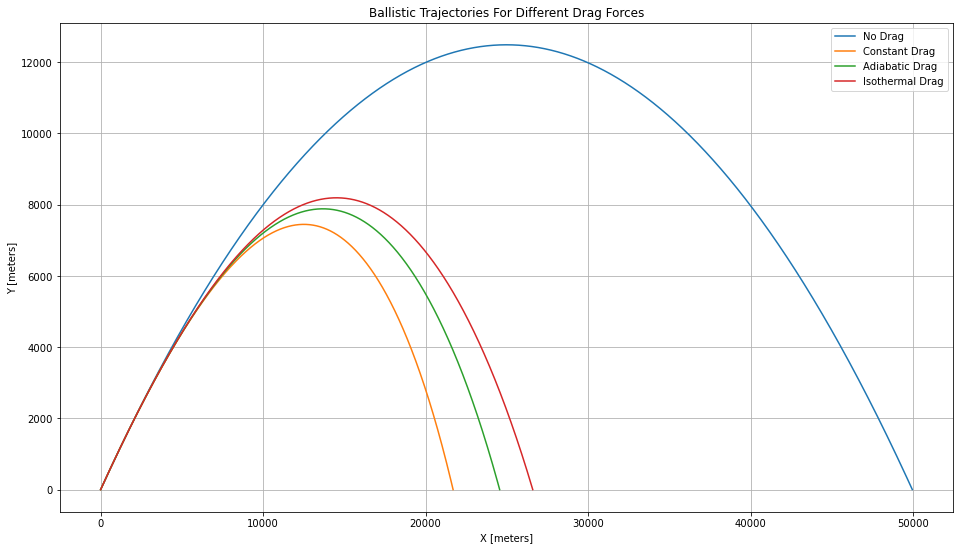

In [7]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes()

plt.plot(*no_drag_trajectory, label='No Drag')
plt.plot(*constant_drag_trajectory, label='Constant Drag')
plt.plot(*adiabatic_drag_trajectory, label='Adiabatic Drag')
plt.plot(*isothermal_drag_trajectory, label='Isothermal Drag')

plt.xlabel('X [meters]')
plt.ylabel('Y [meters]')
plt.title('Ballistic Trajectories For Different Drag Forces')

plt.grid()
plt.legend()
plt.show()

## Response
From the four trajectories shown above, it's rather clear that with no drag force acting against a projectile, the
projectile will fly the furthest, and its trajectory will be parabolic. With the other three drag forces, the parabolic
shape disappears in lieu of shorter ranges do to the work done by their respective forces throughout the flight-path.
It's also relatively clear why the trajectory with a constant drag force has the shortest range of the group. The
trajectory is retarded by the constant drag force, unlike the no-drag case; however, the remaining two
(adiabatic and isothermal) weaken with higher altitudes, therefore doing less work on the projectile in the air and
allowing for further ranges.

# Part 2

## Parameters

In [8]:
dtheta = 0.1
theta0 = 35
theta1 = 65
ntheta = round((theta1 - theta0) / dtheta)

## Currying Functions For A 'Shooting Method' Algorithm

In [9]:
no_drag_function_to_zero         = partial(d_max_range, dtheta=dtheta, forcing=df_no_drag        , dt=dt, v0=v0, g=g)
constant_drag_function_to_zero   = partial(d_max_range, dtheta=dtheta, forcing=df_constant_drag  , dt=dt, v0=v0, g=g)
adiabatic_drag_function_to_zero  = partial(d_max_range, dtheta=dtheta, forcing=df_adiabatic_drag , dt=dt, v0=v0, g=g)
isothermal_drag_function_to_zero = partial(d_max_range, dtheta=dtheta, forcing=df_isothermal_drag, dt=dt, v0=v0, g=g)

## Finding Optimum Launch Angles
`Note: Progress bars below are relative to the maximum number of iterations and are meant to show relative progress,
not absolute`

#### No Drag

In [10]:
print("\nSweeping For The No Drag Case:")
no_drag_optimum_angle         = bisection(no_drag_function_to_zero, theta0, theta1, dtheta, ntheta)
print("Done!")


Sweeping For The No Drag Case:
Done!


#### Constant Drag

In [11]:
print("\nSweeping For The Constant Drag Case:")
constant_drag_optimum_angle   = bisection(constant_drag_function_to_zero, theta0, theta1, dtheta, ntheta)
print("Done!")


Sweeping For The Constant Drag Case:
Done!


#### Adiabatic Drag

In [12]:
print("\nSweeping For The Adiabatic Drag Case:")
adiabatic_drag_optimum_angle  = bisection(adiabatic_drag_function_to_zero, theta0, theta1, dtheta, ntheta)
print("Done!")


Sweeping For The Adiabatic Drag Case:
Done!


#### Isothermal Drag

In [13]:
print("\nSweeping For The Isothermal Drag Case:")
isothermal_drag_optimum_angle = bisection(isothermal_drag_function_to_zero, theta0, theta1, dtheta, ntheta)
print("Done!")



Sweeping For The Isothermal Drag Case:
Done!


## Results

In [14]:
no_drag_optimum_trajectory         = get_trajectory(no_drag_optimum_angle, df_no_drag        , dt, v0, g)
constant_drag_optimum_trajectory   = get_trajectory(constant_drag_optimum_angle, df_constant_drag  , dt, v0, g)
adiabatic_drag_optimum_trajectory  = get_trajectory(adiabatic_drag_optimum_angle, df_adiabatic_drag , dt, v0, g)
isothermal_drag_optimum_trajectory = get_trajectory(isothermal_drag_optimum_angle, df_isothermal_drag, dt, v0, g)

print(f'        No Drag: Optimum Firing Angle =         {no_drag_optimum_angle} [deg], Maximum Range:         {get_max_range(*no_drag_optimum_trajectory)} [meters]')
print(f'  Constant Drag: Optimum Firing Angle =   {constant_drag_optimum_angle} [deg], Maximum Range:   {get_max_range(*constant_drag_optimum_trajectory)} [meters]')
print(f' Adiabatic Drag: Optimum Firing Angle =  {adiabatic_drag_optimum_angle} [deg], Maximum Range:  {get_max_range(*adiabatic_drag_optimum_trajectory)} [meters]')
print(f'Isothermal Drag: Optimum Firing Angle = {isothermal_drag_optimum_angle} [deg], Maximum Range: {get_max_range(*isothermal_drag_optimum_trajectory)} [meters]')


        No Drag: Optimum Firing Angle =         44.990234375 [deg], Maximum Range:         [49949.52379203] [meters]
  Constant Drag: Optimum Firing Angle =   38.779296875 [deg], Maximum Range:   [22057.73044087] [meters]
 Adiabatic Drag: Optimum Firing Angle =  43.701171875 [deg], Maximum Range:  [24574.09275354] [meters]
Isothermal Drag: Optimum Firing Angle = 45.927734375 [deg], Maximum Range: [26602.17560363] [meters]


## Plotting

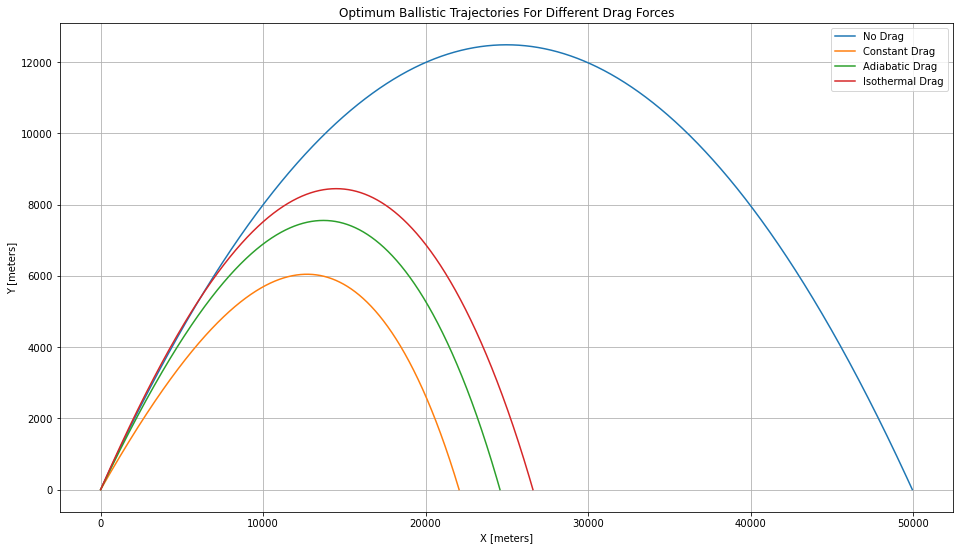

In [15]:
fig2 = plt.figure(figsize=(16, 9))
ax2 = plt.axes()

plt.plot(*no_drag_optimum_trajectory, label='No Drag')
plt.plot(*constant_drag_optimum_trajectory, label='Constant Drag')
plt.plot(*adiabatic_drag_optimum_trajectory, label='Adiabatic Drag')
plt.plot(*isothermal_drag_optimum_trajectory, label='Isothermal Drag')

plt.xlabel('X [meters]')
plt.ylabel('Y [meters]')
plt.title('Optimum Ballistic Trajectories For Different Drag Forces')

plt.grid()
plt.legend()
plt.show()

## Response

bisection error: |theta1-theta0|/2^ntheta

center difference error: dtheta^2

euler error: dt